In [ ]:
import requests
import os

def download_china_map():
    # URL from AliYun DataV (Standard source for China GeoJSONs)
    # 100000_full.json contains the whole country with province boundaries
    url = "https://geo.datav.aliyun.com/areas_v3/bound/100000_full.json"
    filename = "china_provinces.json"
    
    print(f"Downloading map from {url}...")
    
    try:
        response = requests.get(url)
        response.raise_for_status() # Check for errors
        
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Success! Map saved as '{filename}'")
        return filename
    except Exception as e:
        print(f"Failed to download: {e}")
        return None

# Execute the download
map_file = download_china_map()

In [25]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import geopandas as gpd
from shapely.geometry import Point

In [36]:
import matplotlib.pyplot as plt
import platform

# --- CHINESE FONT CONFIGURATION ---
system_name = platform.system()

if system_name == "Windows":
    # SimHei is the standard Chinese font on Windows
    plt.rcParams['font.sans-serif'] = ['SimHei'] 
elif system_name == "Darwin": 
    # MacOS usually uses Heiti TC or Arial Unicode MS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
else:
    # Linux (requires installing a Chinese font, e.g., WenQuanYi)
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']

# This fixes an issue where the minus sign '-' becomes a square when using Chinese fonts
plt.rcParams['axes.unicode_minus'] = False

In [37]:
# 1. SET THE FONT (Run this once)
sys_os = platform.system()
if sys_os == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
elif sys_os == 'Darwin': # Mac
    plt.rcParams['font.sans-serif'] = ['Heiti TC', 'PingFang HK', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [12]:
DATA_PATH = 'migration_data_full_names_and_coords.csv'

In [13]:
data_df = pd.read_csv(DATA_PATH)

In [14]:
data_df.head()

,current_province,current_city,current_county,current_members_live_with,gender,year_born,edu_level,hometown_code,hometown,year_current_flow,...,hometown_Name_County,hometown_lon,hometown_lat,first_Name_Province,first_Name_Prefecture,first_Name_County,first_lon,first_lat,current_lon,current_lat
0,广东省,深圳市,光明新区,4,2,1989,4,360681,江西省鹰潭市贵溪市,2015,...,贵溪市,117.186973,28.188428,江西省,南昌市,青山湖区,115.905297,28.719082,NaN,NaN
1,广东省,深圳市,光明新区,3,2,1981,5,360402,江西省九江市濂溪区,2015,...,濂溪区,116.039436,29.634605,广东省,深圳市,南山区,113.937903,22.554902,NaN,NaN
2,福建省,厦门市,同安区,4,2,1986,4,511623,四川省广安市邻水县,2013,...,邻水县,106.991830,30.258922,福建省,泉州市,丰泽区,118.617882,24.922059,118.102758,24.776209
3,新疆生产建设兵团,第六师,军户农场,3,1,1973,3,652301,新疆维吾尔自治区昌吉回族自治州昌吉市,2000,...,昌吉市,87.059347,44.091644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,北京市,北京市,朝阳区,2,2,1984,5,511702,四川省达州市通川区,2010,...,通川区,107.432388,31.362205,四川省,成都市,武侯区,104.022906,30.610118,116.508837,39.951928


In [17]:
#give me how many registers with 'hometown_lon', 'hometown_lat','first_lon', 'first_lat', 'current_lon', 'current_lat'complete with no NA
#i need to discuss if this is ok jajaja but for the sake of it lets leave it like that
complete_data = data_df.dropna(subset=['hometown_lon', 'hometown_lat', 'first_lon', 'first_lat', 'current_lon', 'current_lat'])

In [26]:
# --- 2. Build Network with Geography ---
def build_geo_network(df, start_year, end_year):
    G = nx.DiGraph()
    
    # Helper to get node ID and Coords
    def get_node_info(row, prefix):
        # Determine column names based on prefix
        name_col = 'current_city' if prefix == 'current' else f'{prefix}_Name_Prefecture'
        lon_col = f'{prefix}_lon'
        lat_col = f'{prefix}_lat'
        
        node_id = row[name_col]
        coords = (row[lon_col], row[lat_col])
        return node_id, coords

    for idx, row in df.iterrows():
        # Extract info
        u_name, u_pos = get_node_info(row, 'hometown')
        v1_name, v1_pos = get_node_info(row, 'first')
        v2_name, v2_pos = get_node_info(row, 'current')
        
        # Add Nodes with Position Data (Idempotent)
        G.add_node(u_name, pos=u_pos)
        G.add_node(v1_name, pos=v1_pos)
        G.add_node(v2_name, pos=v2_pos)

        # Logic: Hometown -> First
        if start_year <= row['year_first_flow'] <= end_year:
            is_intra = (u_name == v1_name)
            if G.has_edge(u_name, v1_name):
                G[u_name][v1_name]['weight'] += 1
            else:
                G.add_edge(u_name, v1_name, weight=1, type='within' if is_intra else 'inter')

        # Logic: First -> Current
        # Only add if locations differ (otherwise it's a "stay")
        if (start_year <= row['year_current_flow'] <= end_year) and (v1_name != v2_name):
            is_intra = (v1_name == v2_name)
            if G.has_edge(v1_name, v2_name):
                G[v1_name][v2_name]['weight'] += 1
            else:
                G.add_edge(v1_name, v2_name, weight=1, type='within' if is_intra else 'inter')
                
    return G

# --- 3. Visualization on Map ---
def plot_migration_map(G):
    # A. Setup the Plot and Map
    fig, ax = plt.subplots(figsize=(15, 12))
    
    # Load world map and filter for China
    # Note: naturalearth_lowres is built-in but coarse. 
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    china = world[world.name == 'China']
    
    # Plot background
    china.plot(ax=ax, color='#f0f0f0', edgecolor='gray')
    ax.set_title("Chinese Migration Network (2010-2020)", fontsize=20)
    ax.set_xlim(73, 136) # Longitude limits of China
    ax.set_ylim(18, 54)  # Latitude limits of China

    # B. Draw Nodes
    # Extract positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Draw nodes as scatter points
    for node, (lon, lat) in pos.items():
        # Size nodes by degree (amount of traffic)
        size = G.degree(node) * 50 + 50
        ax.scatter(lon, lat, s=size, c='skyblue', edgecolors='black', zorder=5)
        # Add labels with slight offset
        ax.text(lon + 0.5, lat + 0.5, node, fontsize=9, zorder=6)

    # C. Draw Edges (Curved Arrows)
    for u, v, data in G.edges(data=True):
        if u == v:
            continue # Skip self-loops on the map (they just clutter)
            
        start = pos[u]
        end = pos[v]
        weight = data['weight']
        edge_type = data['type']
        
        # Style based on type
        color = 'red' if edge_type == 'within' else 'black'
        alpha = 0.6 if edge_type == 'inter' else 0.8
        width = weight * 0.5 # Scale line width by flow volume
        
        # Create Curved Arrow (FancyArrowPatch)
        # rad determines the curvature. 0.2 gives a nice arc.
        arrow = patches.FancyArrowPatch(
            start, end,
            connectionstyle="arc3,rad=0.2", 
            color=color,
            alpha=alpha,
            linewidth=width,
            arrowstyle="-|>", # Arrow head
            mutation_scale=15, # Arrow head size
            zorder=4
        )
        ax.add_patch(arrow)

    plt.axis('off') # Hide axis numbers
    plt.tight_layout()
    plt.show()



In [31]:
# --- Execution ---
G = build_geo_network(complete_data, 2000, 2001)

d:\Tsinghua Classes and Papers\Network Science\migra-net-china\.venv\Lib\site-packages\geopandas\io\file.py:576: UserWarning: Could not parse column 'adcode' as JSON; leaving as string
  return pyogrio.read_dataframe(path_or_bytes, bbox=bbox, **kwargs)


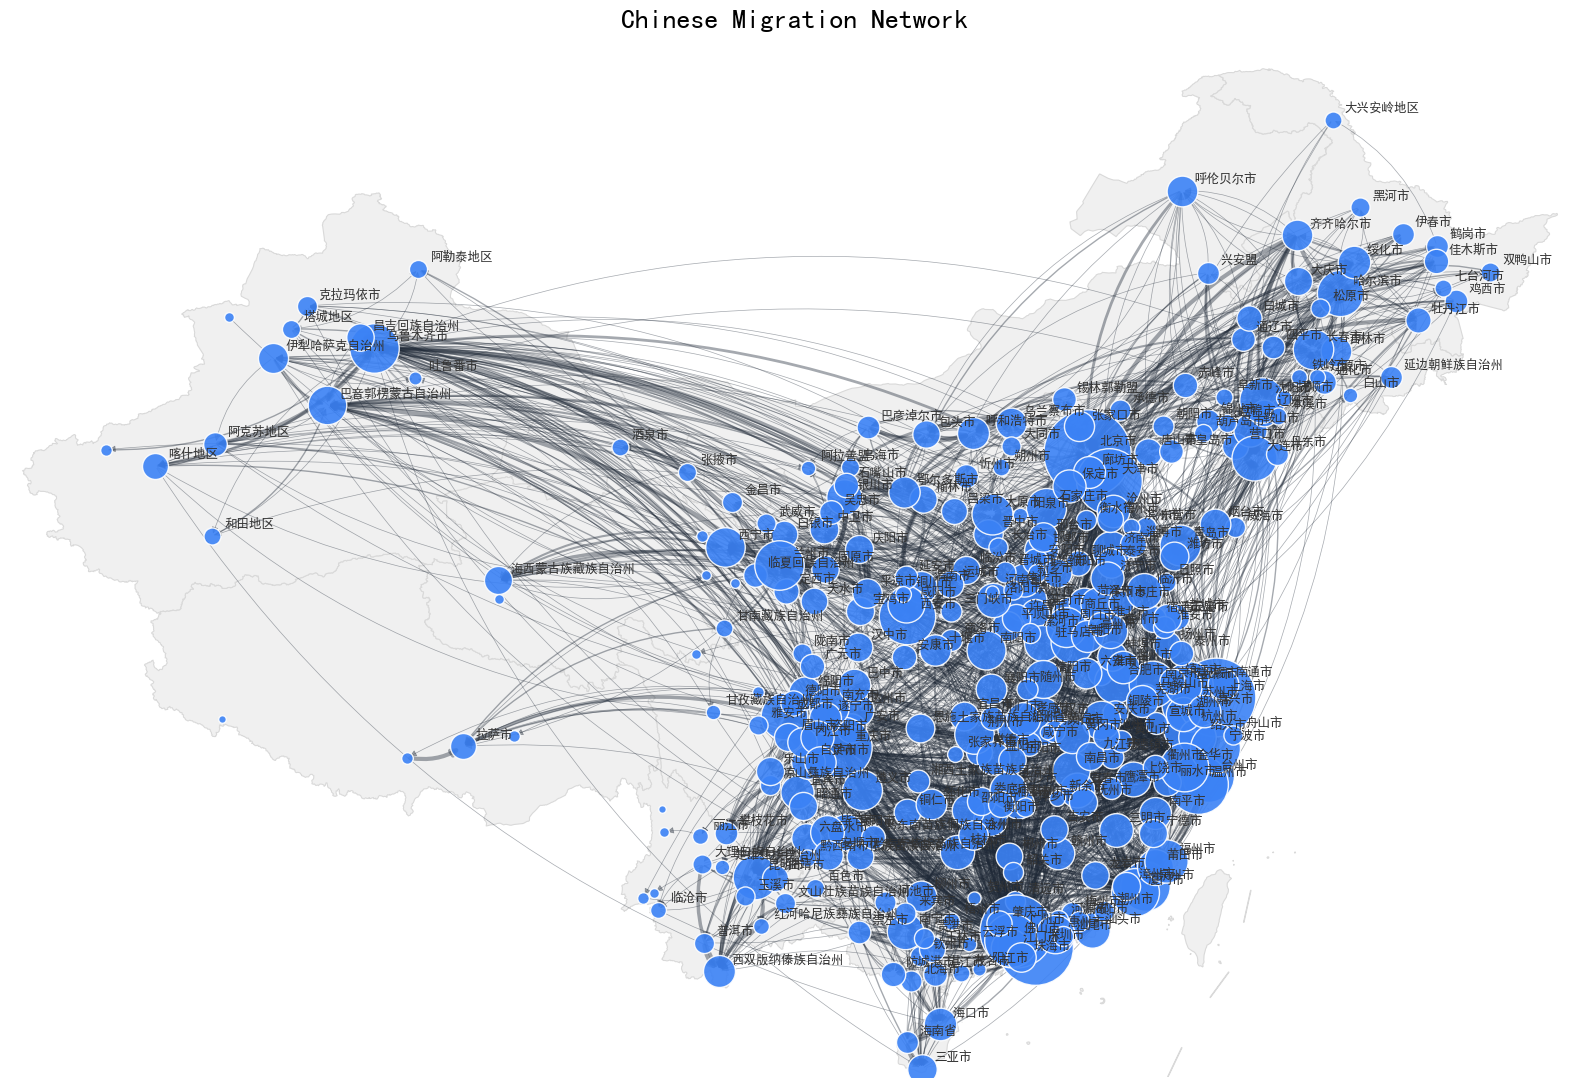

In [38]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import geopandas as gpd

# --- [Insert your Data Setup & Network Building Code here] ---
# (The 'data' dict and 'build_geo_network' function from the previous step)

def plot_migration_map_local(G, map_filename="china_provinces.json"):
    fig, ax = plt.subplots(figsize=(16, 12))
    
    try:
        # 1. Read the local JSON file we just downloaded
        china_map = gpd.read_file(map_filename)
    except Exception as e:
        print(f"Could not load map file '{map_filename}'. Error: {e}")
        return

    # 2. Plot the Map
    # Facecolor = province fill, Edgecolor = border lines
    china_map.plot(ax=ax, color='#f0f0f0', edgecolor='#d9d9d9', linewidth=0.8)
    
    ax.set_title("Chinese Migration Network", fontsize=20, fontweight='bold', pad=20)
    
    # 3. Draw Nodes (Cities)
    pos = nx.get_node_attributes(G, 'pos')
    
    for node, (lon, lat) in pos.items():
        if lon < 70 or lon > 140 or lat < 10 or lat > 60:
            continue # Skip bad coordinates
            
        # Node size based on connections
        degree = G.degree(node)
        size = degree * 20 + 30 
        
        # Draw node
        ax.scatter(lon, lat, s=size, c='#3b82f6', edgecolors='white', linewidth=1, zorder=5, alpha=0.9)
        
        # Label top cities only (to avoid clutter)
        if degree > 2: 
            ax.text(lon + 0.5, lat + 0.3, node, fontsize=9, fontweight='bold', color='#333333', zorder=6)

    # 4. Draw Curved Edges
    for u, v, data in G.edges(data=True):
        if u not in pos or v not in pos or u == v:
            continue
            
        start = pos[u]
        end = pos[v]
        edge_type = data.get('type', 'inter')
        weight = data.get('weight', 1)
        
        # Logic: Red dashed for internal, Solid black for external
        if edge_type == 'within':
             # Skip or draw very subtly
             color = '#ef4444' 
             style = ':'
             alpha = 0.5
        else:
             color = '#1f2937'
             style = '-'
             alpha = 0.4
        
        # Draw Curve
        arrow = patches.FancyArrowPatch(
            start, end,
            connectionstyle="arc3,rad=0.2",
            color=color,
            alpha=alpha,
            linewidth=min(weight * 0.5, 3),
            linestyle=style,
            arrowstyle="-|>", 
            mutation_scale=10, 
            zorder=4
        )
        ax.add_patch(arrow)

    # Focus on the mainland area
    ax.set_xlim(73, 136)
    ax.set_ylim(18, 54)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Run it
# Ensure you ran the 'build_geo_network' code from the previous turn first!
plot_migration_map_local(G, "china_provinces.json")